# Customer Segmentation

In this notebook I will use K-Means Clustering to identify homogeneous groups of customers in "Mall Customer Segmentation Data" dataset dowloaded from Kaggle.

https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import math
import plotly.figure_factory as ff
from KMeansCluster import KMeansCluster
import plotly.express as px
from sklearn.cluster import KMeans

## Data Processing

Import data and process columns for cleaner names as well as a one-hot-encoded version of gender.

In [2]:
#Misc
Data = pd.read_csv(r"Mall_Customers.csv")
Data["Gender"] = Data["Gender"].apply(lambda x: 1 if x == "Male" else 0)
Data["AnnualIncome"] = Data["Annual Income (k$)"]
Data["SpendingScore"] = Data["Spending Score (1-100)"]
Data = Data.drop("Annual Income (k$)", axis=1)
Data = Data.drop("Spending Score (1-100)", axis=1)

PerVars = ["SpendingScore"] #List of Percentage variables for plotting
MonVars = ["AnnualIncome"] #List of currency vars for plotting
Data["All"] = np.ones(shape = (len(Data), 1)) #For Violin Plots

In [3]:
Data.isnull().sum()

CustomerID       0
Gender           0
Age              0
AnnualIncome     0
SpendingScore    0
All              0
dtype: int64

## Functions

In [56]:
def scatter(Df, PlotVar, Hue, Y, Title):
    
    '''
    Produces a plot of data pulled from specified dataframe split by a certain binary population
    PlotVars defines the independent variable
    Hue defines the population for which to split the plots
    Y is the dependent variable
    Title is title of the plot
    '''
    
    Multiplier = 1000 if "Income" in PlotVar else 1

    fig = go.Figure()

    fig.add_trace(  
        go.Scatter(
            x = Df[Df[Hue] == 1][PlotVar]*Multiplier
            , y=Df[Df[Hue] == 1][Y]
            , legendgroup=Hue + " = 1"
            , name=Hue + " = 1"
            , mode='markers'
            , line=dict(color='red')
            , marker=dict(size=10, opacity=0.9)
            , showlegend= True))

    fig.add_trace(  
        go.Scatter(
            x = Df[Df[Hue] == 0][PlotVar]*Multiplier
            , y=Df[Df[Hue] == 0][Y]
            , legendgroup=Hue + " = 0"
            , name=Hue + " = 0"
            , mode='markers'
            , line=dict(color='blue')
            , marker=dict(size=10, opacity=0.9)
            , showlegend= True))

    fig.update_xaxes(
        zeroline = True
        , showgrid = True
        , title = PlotVar
        , ticksuffix = "%" if PlotVar in PerVars else ""
        , tickprefix = "$" if PlotVar in MonVars else ""
        , range = [0.95*Multiplier*np.min(Df[PlotVar]), 1.05*Multiplier*np.max(Df[PlotVar])])

    fig.update_yaxes(
        zeroline=True
        , showgrid=True
        , ticksuffix = "%" if Y in PerVars else ""
        , tickprefix = "$" if Y in MonVars else ""
        , range = [0.95*np.min(Df[Y]), 1.05*np.max(Df[Y])]
        , title = Y)
    
    
    fig.update_layout(
        title = dict(text=Title, font=dict(size=17)))

    fig.update_annotations(
        font = dict(size=14))
    
    fig.show("png", height=600, width=900)

In [58]:
def DistributionPlot(Df, PlotVar):
    '''
    Plots the distribution of a given variable in a dataframe
    '''
    Labels = [i for i in range(0, 100, 10)]
    
    fig = ff.create_distplot(
            hist_data = [Df[PlotVar].values.tolist()]
            , group_labels = [str(PlotVar) + " Distribution"]
            , bin_size=3.5)
    
    fig.update_xaxes(
    zeroline = True
    , showgrid = True
    , title=PlotVar)


    fig.update_yaxes(
        zeroline=True
        , showgrid=True
        , title="Distribution")


    fig.update_layout(
        title = dict(text=str(PlotVar) + " Distribution"
                     , font=dict(color="Black", size=20))
        , font = dict(color="Black", size=10)
        , height = 700
        , width = 1100
        , legend_title='Legend')

    fig.show("png", height=600, width=900)

In [60]:
def Plot(Df, Y, Hue):
    
    '''
    Generates a violin plot with data pulled from a specified dataframe.
    Dependent variable is specified as Y
    Hue splits the dependent variable into two populations according to a specified binary classifier.
    Can be Gender, Retired etc.
    '''
    
    Multiplier = 1000 if "Income" in Y else 1
    
    fig = go.Figure()

    fig.add_trace(
        go.Violin(
            x = Df["All"]
            , y=Df[Y][Df[Hue] == 0]*Multiplier
            , name=Hue + " = 0"
            , side="positive"
            , showlegend= True
            , box = dict(visible=True)
            , meanline = dict(visible=True)))

    fig.add_trace(
        go.Violin(
            x = Df["All"]
            , y=Df[Y][Df[Hue] == 1]*Multiplier
            , name=Hue + " = 1"
            , side="negative"
            , showlegend= True
            , box = dict(visible=True)
            , meanline = dict(visible=True)))
    
    fig.update_xaxes(
        zeroline = True
        , showgrid = True
        , showticklabels = False)

    fig.update_yaxes(
        zeroline=True
        , showgrid=True
        , ticksuffix = "%" if Y in PerVars else ""
        , tickprefix = "$" if Y in MonVars else ""
        , title=Y)
    
    fig.update_layout(
        title = dict(text=Y+" Split By "+ Hue)
        , height = 600
        , width = 900)

    fig.update_annotations(
        font = dict(size=14))

    fig.show("png", height=800, width=800)

In [61]:
def InertiaPlot(DataFrame, Vars):
    
    '''
    Calculates inertia for a variety of K's
    Plots inertia for each model
    Allows user to find optimal K.
    '''
    
    Inertia = {}
    
    for N in range(1 , 10):
        Mod = KMeansCluster(300, N)

        Mod = Mod.fit(DataFrame[Vars])

        Preds = Mod.Predict(DataFrame[Vars])

        Inertia[N] = Mod.Inertia


    fig = go.Figure()

    fig.add_trace(  
        go.Scatter(
            x = [i for i in range(1 , 7)]
            , y=[Inertia[i] for i in range(1 , 10)]
            , legendgroup="Inertia"
            , name="Inertia"
            , mode='lines+markers'
            , marker=dict(size=10, opacity=0.9)
            , showlegend= True))

    fig.update_xaxes(
        zeroline = True
        , showgrid = True
        , title = "K")

    fig.update_yaxes(
        zeroline=True
        , showgrid=True
        , title="Inertia")


    fig.update_layout(
        title = dict(text="Inertia vs. K", font=dict(size=17)))

    fig.update_annotations(
        font = dict(size=14))

    fig.show("png", height=800, width=800)

## EDA

- We can see that there is a very small amount of data points in this set - only 200.
- The average age of a customer is 39 years, ranging from 18 to 70 years of age.
- Average Income P/A is $60.5k
- 44% of customers are Male
- Spending score ranges between 1 and 100 with an average value of 50.

In [62]:
Data.describe()

,CustomerID,Gender,Age,AnnualIncome,SpendingScore,All,Clusters
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000
mean,100.500000,0.440000,38.850000,60.560000,50.200000,1.0,2.690000
std,57.879185,0.497633,13.969007,26.264721,25.823522,0.0,1.576811
min,1.000000,0.000000,18.000000,15.000000,1.000000,1.0,1.000000
25%,50.750000,0.000000,28.750000,41.500000,34.750000,1.0,1.000000
50%,100.500000,0.000000,36.000000,61.500000,50.000000,1.0,3.000000
75%,150.250000,1.000000,49.000000,78.000000,73.000000,1.0,4.000000
max,200.000000,1.000000,70.000000,137.000000,99.000000,1.0,5.000000


In [63]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
CustomerID       200 non-null int64
Gender           200 non-null int64
Age              200 non-null int64
AnnualIncome     200 non-null int64
SpendingScore    200 non-null int64
All              200 non-null float64
Clusters         200 non-null int64
dtypes: float64(1), int64(6)
memory usage: 11.0 KB


### Annual Income, Spending Score and Gender

We can see a very clear group of customers forming in the centre, with spending scores between 40% and 60%, along with an annual income between £45k and $65k.

This could be seen as the "Average Customer", with the other groups of customers warranting more tailored marketing strategies/treatment - assuming this is the purpose for such analysis.

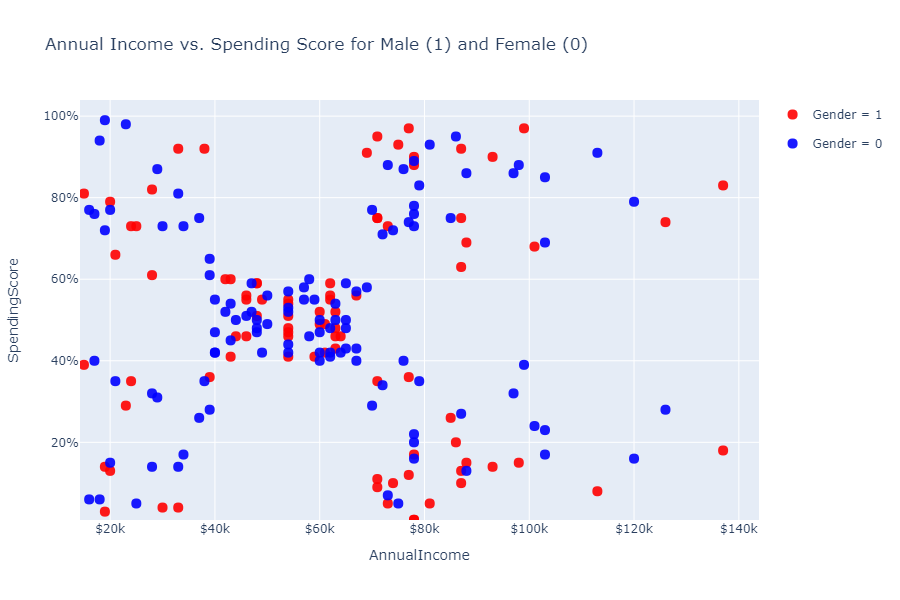

In [64]:
scatter(Data, "AnnualIncome", "Gender", "SpendingScore", "Annual Income vs. Spending Score for Male (1) and Female (0)")

### Annual Income, Age and Gender

It seems the clusters are not as clear in this graph, however, that does not mean that age does not provide any splitting power. 

I was surprised to see that most higher earners are in there 30's. Earnings can peak at different ages for different demographics, this is beyond the scope of this notebook but may provide some explanation.

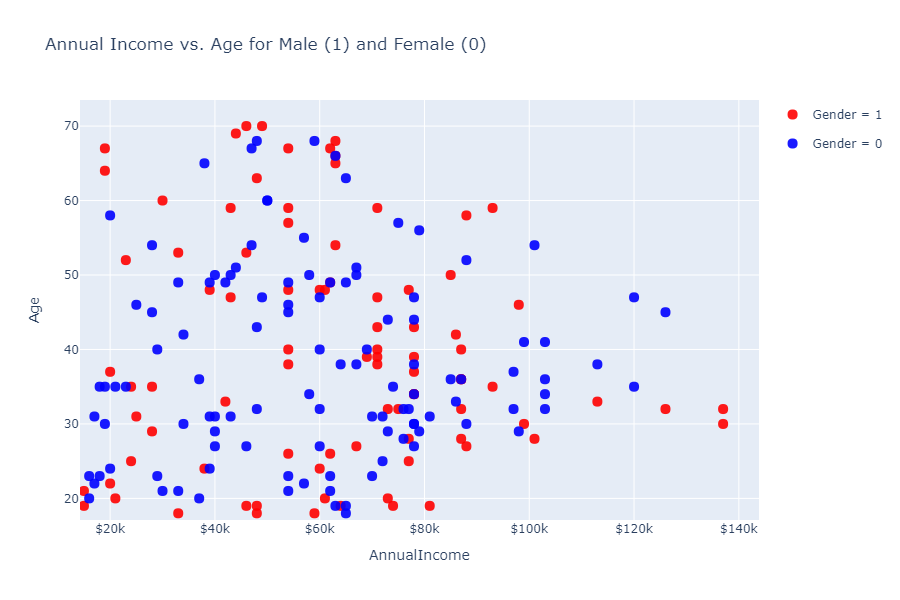

In [65]:
scatter(Data, "AnnualIncome", "Gender", "Age", "Annual Income vs. Age for Male (1) and Female (0)")

### Univariate Distributions

- It seems as though there is a relatively sharp decrease volume for earnings above $80k
- The Bulk of our customers are lower in age, a positively skewed distribution.
- Spending score has an odd but fairly symmetrical distribution, possibly a scaled scorecard? 

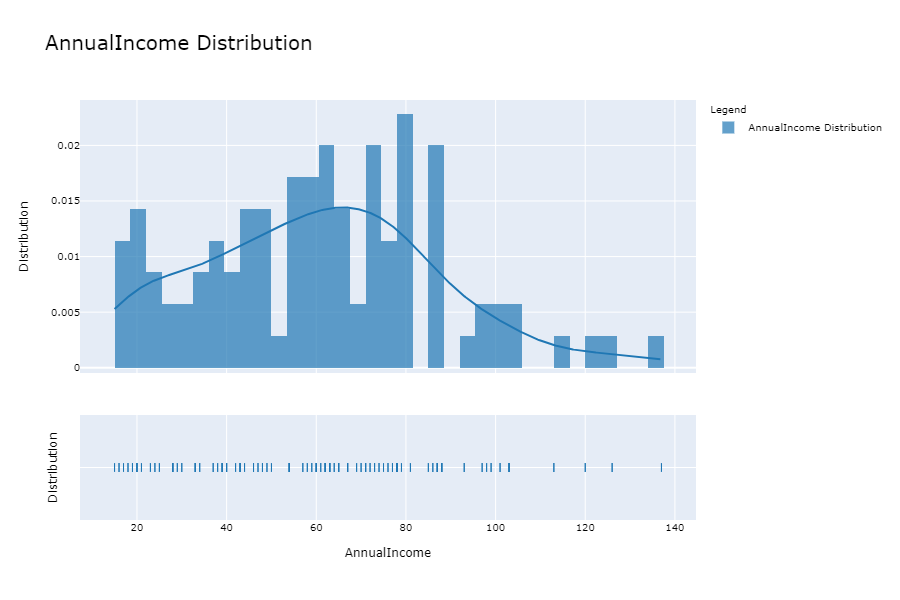

In [66]:
DistributionPlot(Data, "AnnualIncome")

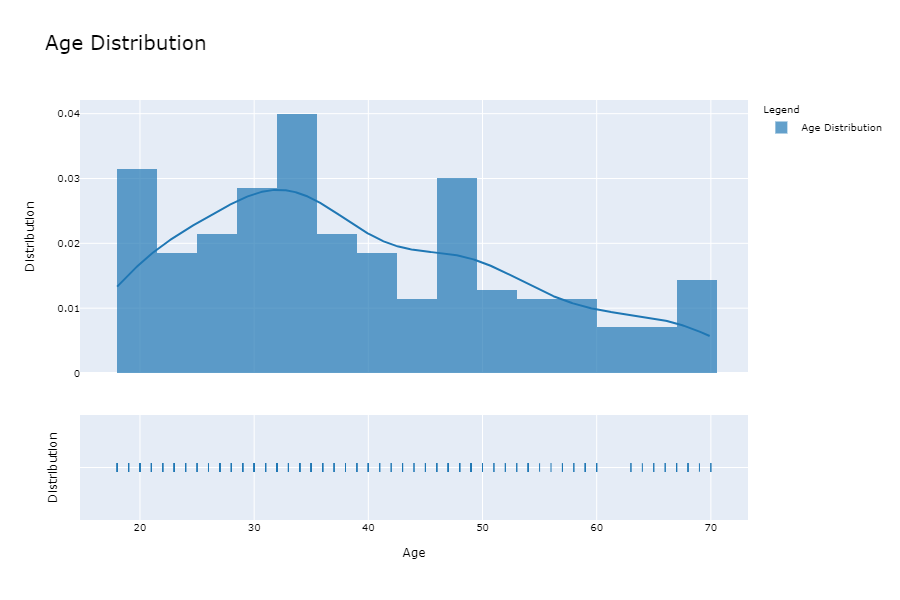

In [67]:
DistributionPlot(Data, "Age")

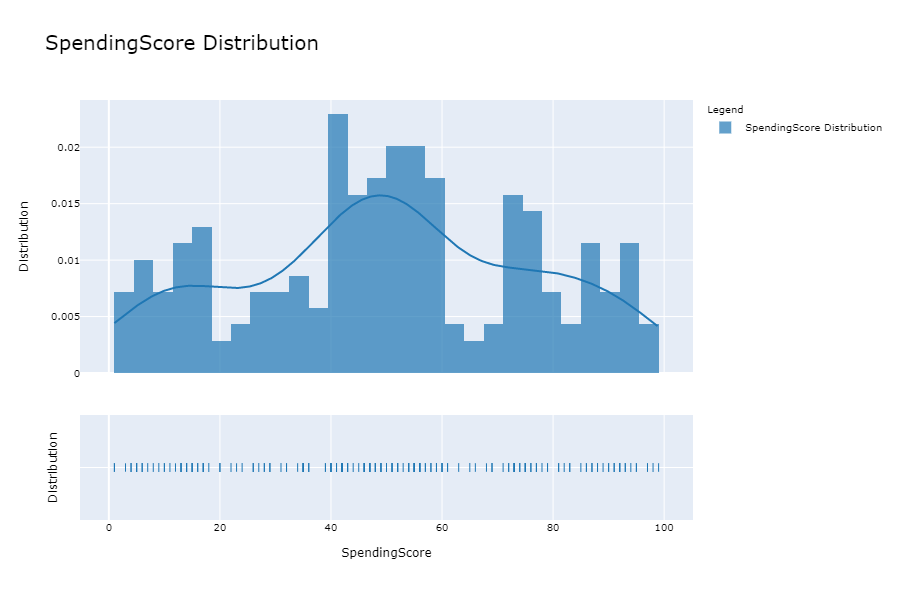

In [68]:
DistributionPlot(Data, "SpendingScore")

### Violin Plots

- The female population is slightly older than the male, with a similar mean.
- The male population are earning around $1,000 dollars more on average than the female population.
- The male population have a slightly higher spending score on average, however, more females have very high spending scores.

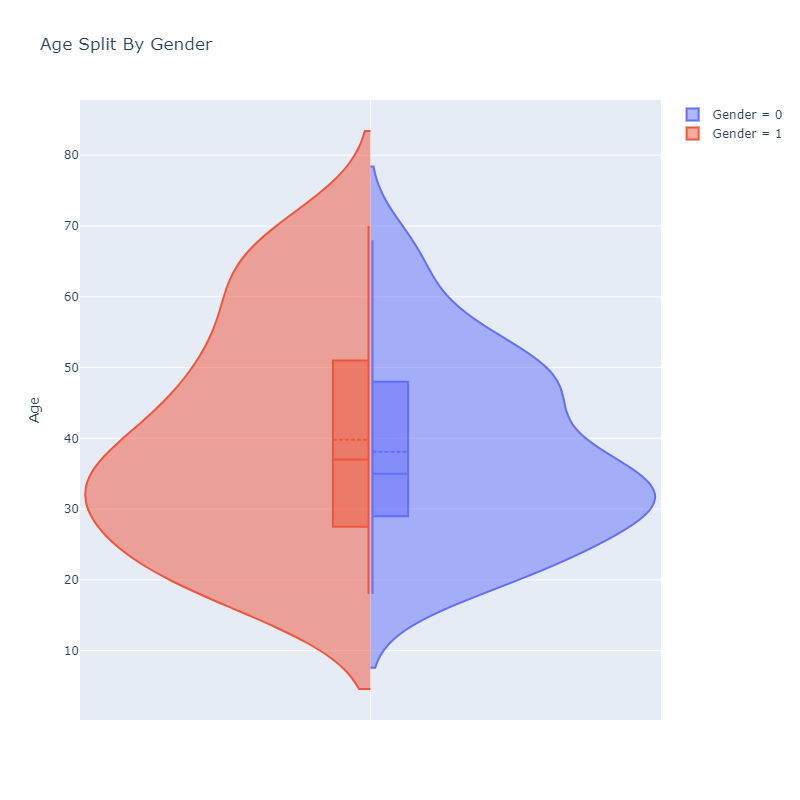

In [69]:
Plot(Data, "Age", "Gender")

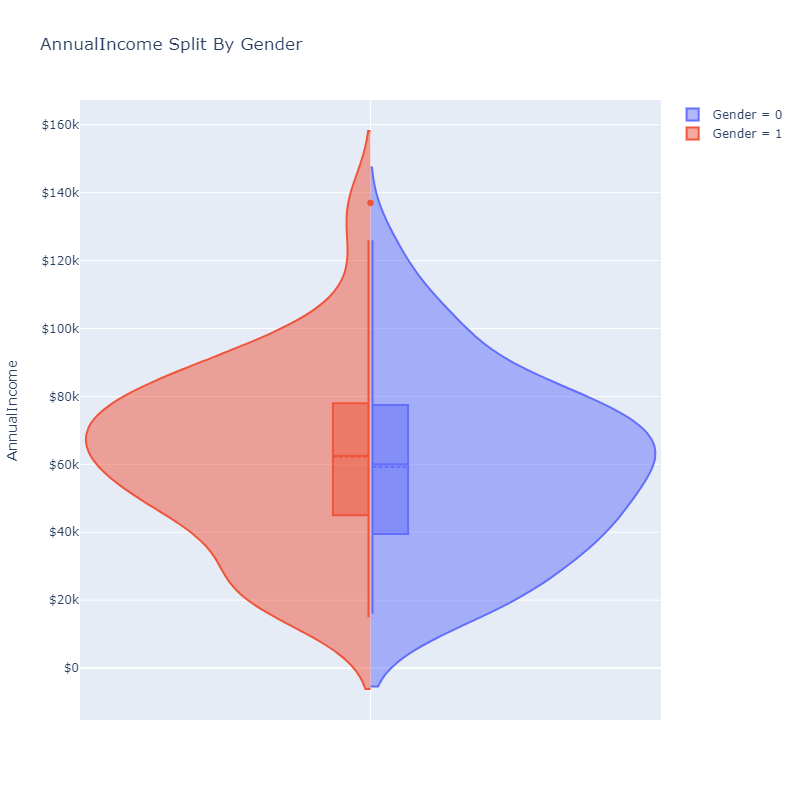

In [70]:
Plot(Data, "AnnualIncome", "Gender")

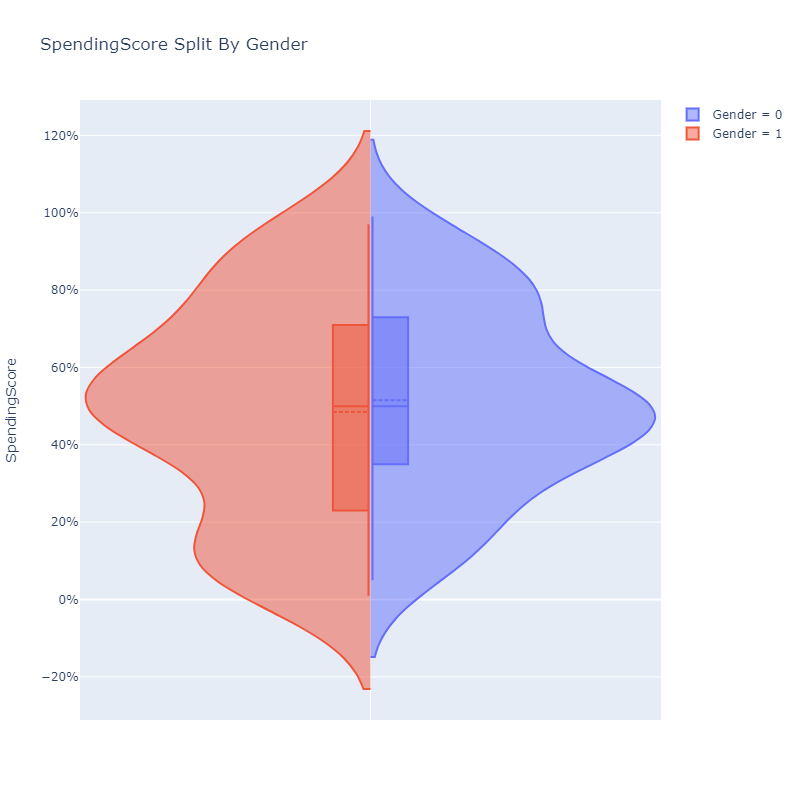

In [71]:
Plot(Data, "SpendingScore", "Gender")

## Modelling

## Annual Income and Spending Score

We will now plot inertia (Sum of Euclidian Distances between points and respective centroids) as an evaluation metric to determine the optimal value for K. As K increases, there will be fewer points in each cluster. This will increase cluster homogeneity, however, may decrease Cluster separation, and defeat the point of clustering . We will use the elbow method to balance the number of clusters with inertia/performance.


We can see that using just income and spending score gives a relatively uncertain determination of the optimal value for K. The performance is not awful, but we could possibly improve performance by adding age. 

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning:

invalid value encountered in true_divide



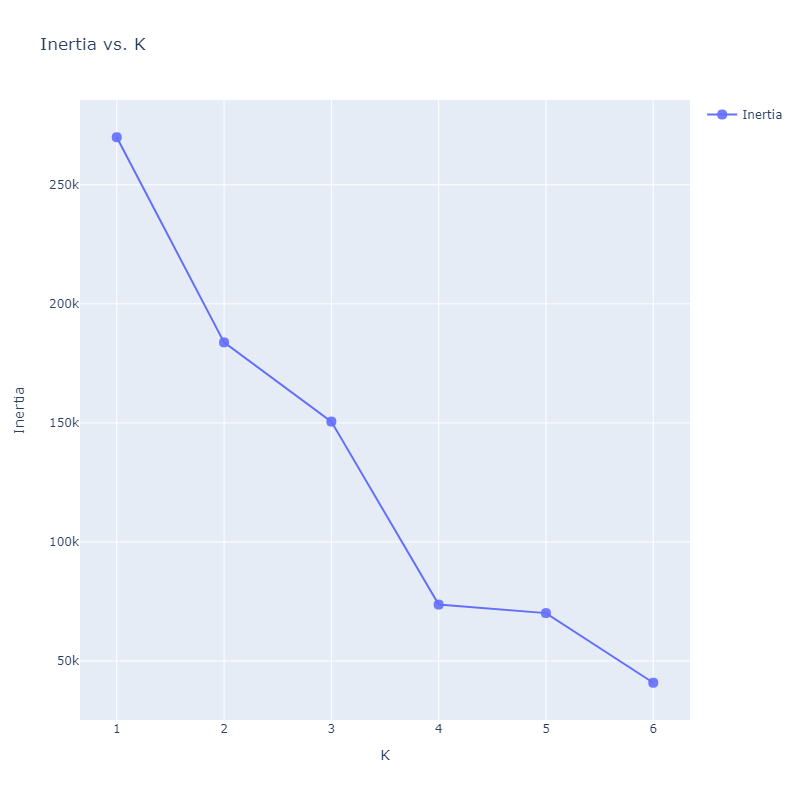

In [72]:
InertiaPlot(Data, ["AnnualIncome", "SpendingScore"])

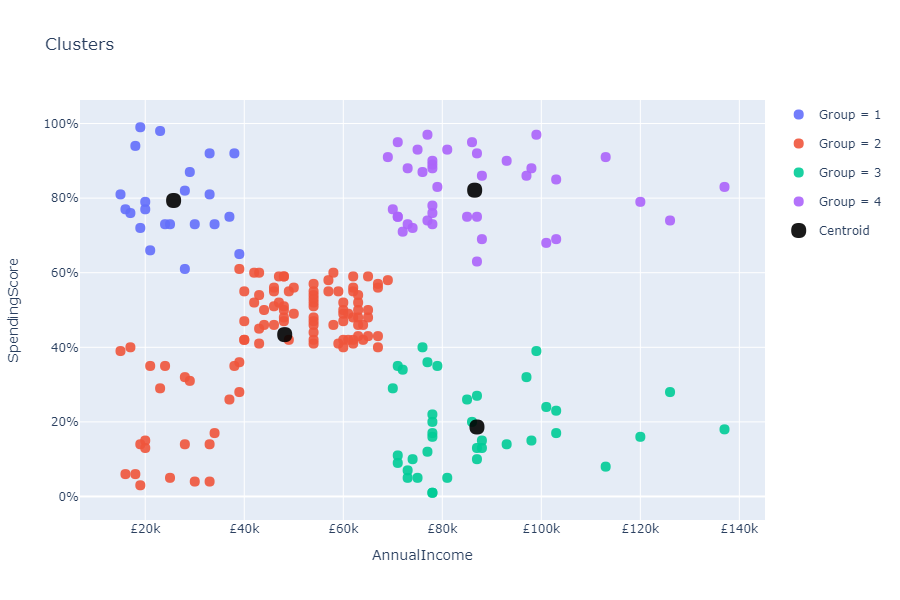

In [90]:
Mod = KMeansCluster(500, 4)
Mod = Mod.fit(Data[["AnnualIncome", "SpendingScore"]])
Data["Clusters"] = Mod.Predict(Data[["AnnualIncome", "SpendingScore"]])


fig = go.Figure()

for i in Data["Clusters"].sort_values().unique():
    fig.add_trace(  
        go.Scatter(
            x = Data[Data["Clusters"] == i]["AnnualIncome"]*1000
            , y=Data[Data["Clusters"] == i]["SpendingScore"]
            , legendgroup="Group" + " = " + str(i)
            , name="Group" + " = " + str(i)
            , mode='markers'
            , marker=dict(size=10, opacity=0.9)
            , showlegend= True))
    
    
fig.add_trace(  
    go.Scatter(
        x = [Centroid[0]*1000 for Centroid in Mod.Centroid]
        , y = [Centroid[1] for Centroid in Mod.Centroid]
        , name = "Centroid"
        , mode='markers'
        , marker=dict(size=15, opacity=0.9, color="Black")
        , showlegend= True))
    

fig.update_xaxes(
    zeroline = True
    , showgrid = True
    , title = "AnnualIncome"
    , tickprefix="£")

fig.update_yaxes(
    zeroline=True
    , showgrid=True
    , title="SpendingScore"
    , ticksuffix="%")


fig.update_layout(
    title = dict(text="Clusters", font=dict(size=17)))

fig.update_annotations(
    font = dict(size=14))

fig.show("png", height=600, width=900)

## Annual Income, Spending Score and Age

It's a lot easier to see the optimal K value here, and the algorithm clearly defines homogeneous groups of customers in this 3-dimensional feature space.

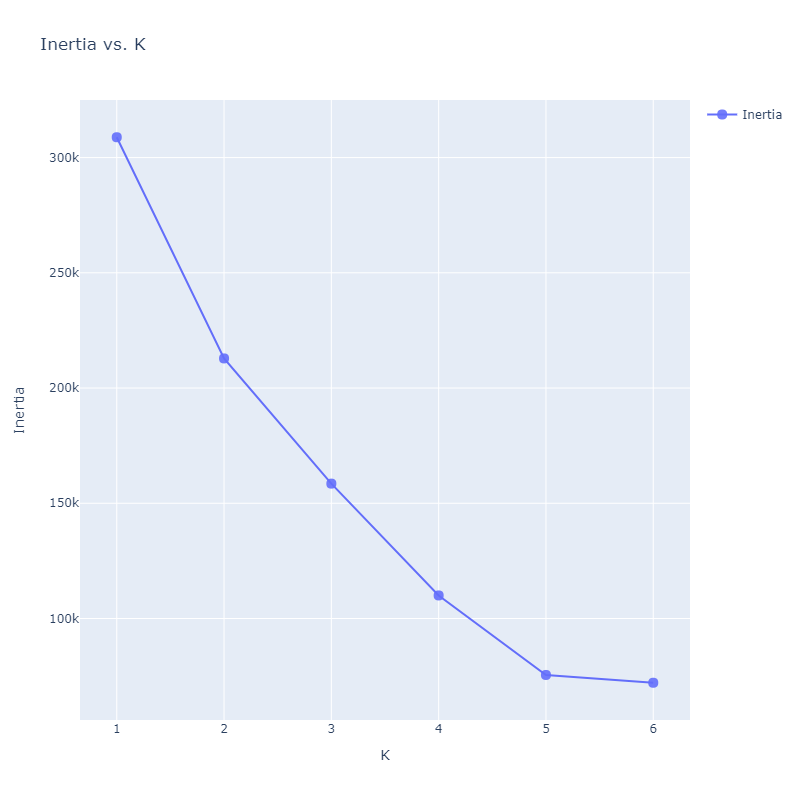

In [74]:
InertiaPlot(Data, ["AnnualIncome", "SpendingScore", "Age"])

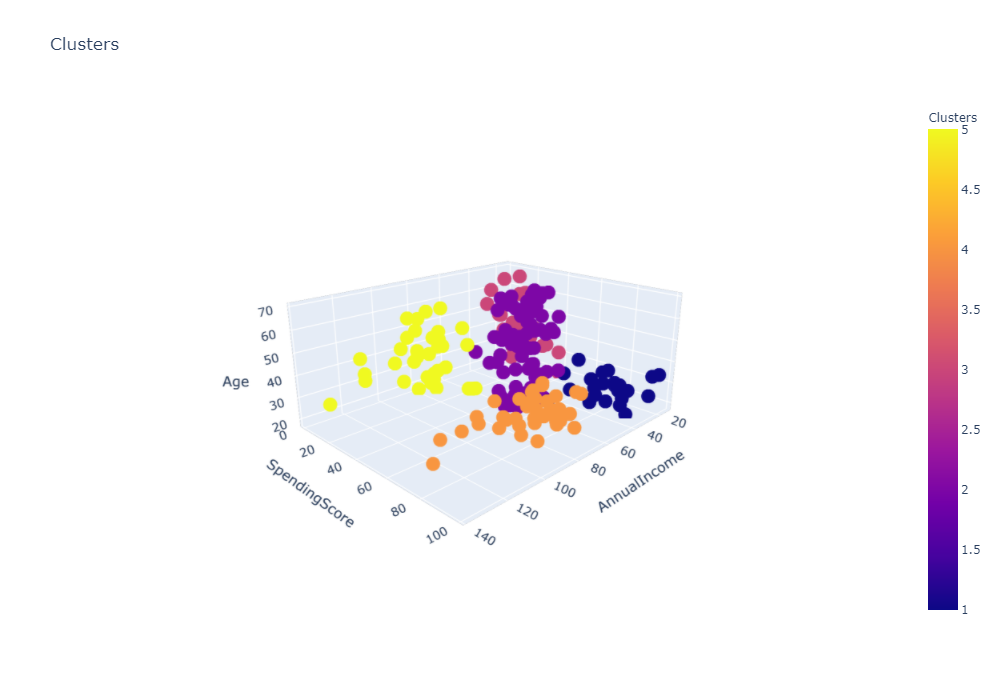

In [86]:
Mod = KMeansCluster(500, 5)
Mod = Mod.fit(Data[["AnnualIncome", "SpendingScore", "Age"]])
Data["Clusters"] = Mod.Predict(Data[["AnnualIncome", "SpendingScore", "Age"]])

fig = px.scatter_3d(Data, x='AnnualIncome', y='SpendingScore', z='Age',
              color='Clusters', title="Clusters")

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2, y=2, z=1))

fig.update_layout(scene_camera=camera)


fig.show("png", height=700, width=1000)

## Test against Sklearns K-Means

We can be sure that the algorithm I coded from scratch is correct, this is down to how similar my algorithm performs alongisde Sklearn's KMeans algorithm.

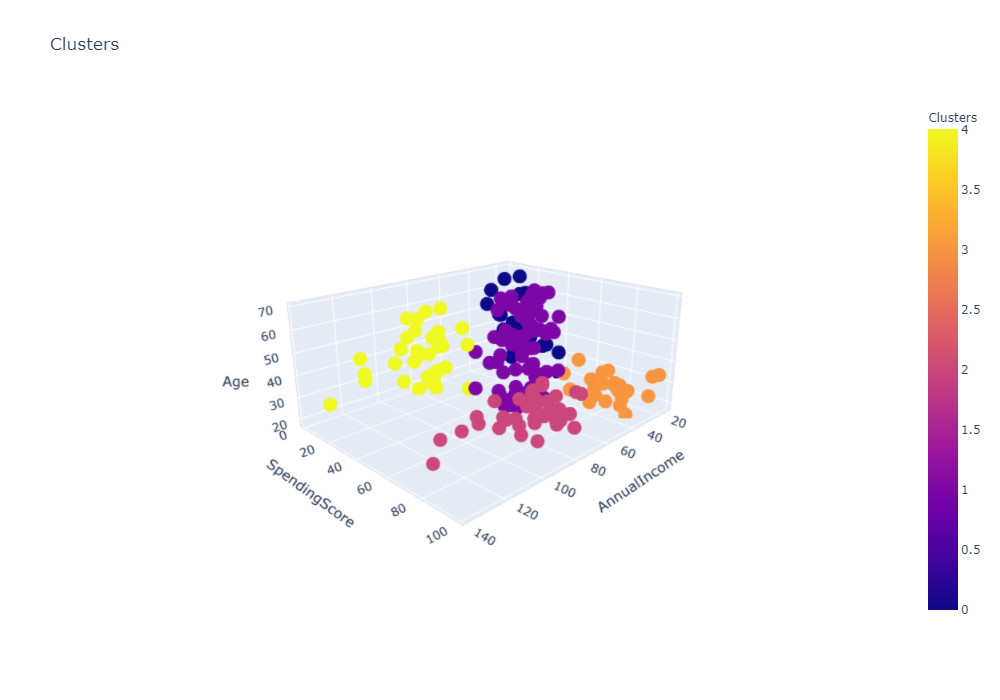

In [87]:
Mod = KMeans(n_clusters=5, max_iter=500).fit(Data[["AnnualIncome", "SpendingScore", "Age"]])

Test = pd.DataFrame()
Test["AnnualIncome"] = Data["AnnualIncome"]
Test["SpendingScore"] = Data["SpendingScore"]
Test["Age"] = Data["Age"]
Test["Clusters"] = Mod.predict(Data[["AnnualIncome", "SpendingScore", "Age"]])



fig = px.scatter_3d(Test, x='AnnualIncome', y='SpendingScore', z='Age',
              color='Clusters', title="Clusters")

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2, y=2, z=1))

fig.update_layout(scene_camera=camera)


fig.show("png", height=700, width=1000)

In [88]:
Mod.inertia_

75350.77917248776